In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import sys
import os
current_dir = os.getcwd()
core_dir = os.path.dirname(current_dir)
Logic_dir = os.path.dirname(core_dir)
project_root = os.path.dirname(Logic_dir)
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
import pandas as pd

ratings_path = project_root+'/data/ratings.csv'
movies_path = project_root+'/data/movies.csv'


ratings = pd.read_csv(ratings_path, sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv(movies_path, sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [4]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [6]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [8]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [9]:
def genre_recommendations(title, n=10):
    #TODO
    idx = movies.loc[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]
    

In [10]:
# Example
genre_recommendations('GoldenEye (1995)')

345     Clear and Present Danger (1994)
543           Surviving the Game (1994)
724                    Rock, The (1996)
788                     Daylight (1996)
825               Chain Reaction (1996)
978                 Maximum Risk (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
1693                   Firestorm (1998)
3686          Perfect Storm, The (2000)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
ratings = pd.read_csv(ratings_path, sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'rating'])

movies = pd.read_csv(movies_path, sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

data = pd.merge(ratings, movies, on='movie_id')

In [13]:
data.head(5)

,user_id,movie_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,My Fair Lady (1964),Musical|Romance
3,1,3408,4,Erin Brockovich (2000),Drama
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [14]:
data_genres = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [15]:
data_genres.head(5)

,user_id,movie_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,James and the Giant Peach (1996),Animation
1,1,661,3,James and the Giant Peach (1996),Children's
1,1,661,3,James and the Giant Peach (1996),Musical
2,1,914,3,My Fair Lady (1964),Musical


In [16]:
def get_top_n_similar_users(user_id, n=5):
    user_genre_matrix = data_genres.pivot_table(index='user_id', columns='genres', aggfunc='size', fill_value=0)
    user_genre_matrix = user_genre_matrix.div(user_genre_matrix.sum(axis=1), axis=0)
    user_genre_matrix = user_genre_matrix.fillna(0)
    user_genre_matrix_values = user_genre_matrix.values

    user_vec = user_genre_matrix_values[user_id - 1]

    user_similarity = cosine_similarity(user_genre_matrix_values, [user_vec]).flatten()

    similar_indices = np.argsort(user_similarity)[::-1]
    top_n_indices = similar_indices[similar_indices != (user_id - 1)][:n]

    return top_n_indices + 1, user_similarity[top_n_indices]

In [17]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    similar_users, scores = get_top_n_similar_users(user_id, n_similar_users)
    
    user_movies = set(data.loc[data['user_id'] == user_id, 'movie_id'])
    
    similar_users_movies = {}
    for similar_user_id, score in zip(similar_users, scores):
        similar_movies = set(data.loc[data['user_id'] == similar_user_id, 'movie_id'])
        for movie in similar_movies:
            if movie not in user_movies:
                if movie not in similar_users_movies:
                    similar_users_movies[movie] = 0
                similar_users_movies[movie] += score
    
    sorted_movies = sorted(similar_users_movies.items(), key=lambda x: x[1], reverse=True)
    
    top_movie_ids = [movie_id for movie_id, score in sorted_movies[:n_recommendations]]
    recommended_movies = movies[movies['movie_id'].isin(top_movie_ids)]
    
    return recommended_movies

In [18]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [19]:
recommended_movies

,movie_id,title,genres
33,34,Babe (1995),Children's|Comedy|Drama
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
900,912,Casablanca (1942),Drama|Romance|War
1019,1032,Alice in Wonderland (1951),Animation|Children's|Musical
2009,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
2011,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
2012,2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
2018,2087,Peter Pan (1953),Animation|Children's|Fantasy|Musical
2027,2096,Sleeping Beauty (1959),Animation|Children's|Musical
2789,2858,American Beauty (1999),Comedy|Drama


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [20]:
ratings = pd.read_csv(ratings_path, sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv(movies_path, sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [21]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# calculate rating matrix
R = Ratings.to_numpy()

In [23]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R, k = 100)
sigma = np.diag(sigma)

In [24]:
all_user_predicted_ratings = U @ sigma @ Vt

In [25]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.132589,0.168593,0.354256,-0.025984,0.146412,-0.124057,-0.061609,0.079215,0.025162,-0.364816,...,-0.102774,0.008839,0.028378,-0.096139,-0.042566,0.007125,-0.112891,0.017840,0.081946,-0.192445
1,0.527079,0.278227,0.076380,-0.021186,0.036919,1.129623,-0.053878,0.119751,0.095301,1.710964,...,0.004399,-0.010270,-0.021023,0.078350,-0.008892,-0.431597,-0.238003,-0.008461,0.035765,0.036354
2,2.158835,0.384824,0.298305,-0.117883,-0.003051,0.096564,-0.008272,0.074512,-0.009878,1.075564,...,0.053171,0.007187,0.042976,0.069483,0.040690,0.014647,0.173379,0.076715,0.047036,-0.239905
3,0.170102,0.139338,0.049499,0.040963,-0.008043,0.282204,-0.054760,-0.003053,0.011237,-0.416429,...,-0.048642,-0.003518,0.013642,-0.002003,-0.031724,-0.185492,0.015460,-0.036204,-0.009392,-0.129042
4,0.374352,-0.418232,-0.022549,0.160691,-0.242144,1.526043,-0.135583,-0.071767,-0.139569,0.070673,...,0.026708,0.018442,-0.039586,-0.114310,-0.129007,-0.562672,0.229044,-0.085522,0.075491,0.013107


In [26]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)

    user_data = original_ratings[original_ratings.user_id == (userID)]

    # merfe movies data with user_data
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )


    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [27]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [28]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [29]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),Drama
285,4375,175,5,4374,174,Kids (1995),Drama
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)",Action|Drama|Romance|Thriller
65,4375,3809,5,4374,3808,What About Bob? (1991),Comedy
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)",Drama|Thriller
270,4375,150,5,4374,149,Apollo 13 (1995),Drama
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",Horror
125,4375,349,5,4374,348,Clear and Present Danger (1994),Action|Adventure|Thriller
60,4375,288,5,4374,287,Natural Born Killers (1994),Action|Thriller
141,4375,47,5,4374,46,Seven (Se7en) (1995),Crime|Thriller


#### Evaluation

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2)

train_ratings = train_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
R_train = train_ratings.values

U_train, sigma_train, Vt_train = svds(R_train, k = 50)
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train)
preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns = train_ratings.columns)

def predict_rating(user_id, movie_id):
    # TODO
    user_row_number = user_id
    movie_col_number = movie_id
    if user_row_number >= preds_train.shape[0] or movie_col_number >= preds_train.shape[1]:
        return np.nan
    pred = preds_train.iloc[user_row_number, movie_col_number]
    return pred

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 3.663715707050373


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [31]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm

In [32]:
ratings = pd.read_csv(ratings_path, sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'rating'])

movies = pd.read_csv(movies_path, sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [33]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings, device='cpu'):
        #TODO
        self.ratings = ratings
        user_ids = ratings['user_id'].to_numpy()
        self.user_ids = torch.tensor(user_ids, dtype=torch.long).to(device)
        movie_ids = ratings['movie_id'].to_numpy()
        self.movie_ids = torch.tensor(movie_ids, dtype=torch.long).to(device)
        ratings = ratings['rating'].to_numpy()
        self.ratings = torch.tensor(ratings, dtype=torch.float).to(device)


    def __len__(self):
        #TODO
        return len(self.ratings)

    def __getitem__(self, idx):
        #TODO
        user_id = self.user_ids[idx]
        movie_id = self.movie_ids[idx]
        rating = self.ratings[idx]
        return user_id, movie_id, rating
    

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        #TODO
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size*2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, user, movie):
        #TODO
        user_embedding = self.user_embedding(user)
        movie_embedding = self.movie_embedding(movie)
        x = torch.cat([user_embedding, movie_embedding], dim=1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    

# Hyperparameters
BATCH_SIZE = 256
EMBEDDING_SIZE = 128
LEARNING_RATE = 0.0005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create the dataset and dataloader
train, test = train_test_split(ratings, test_size=0.1)
train, eval = train_test_split(train, test_size=1/9)

train_dataset = RatingsDataset(train, device)
eval_dataset = RatingsDataset(eval, device)
test_dataset = RatingsDataset(test, device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Initialize the model, loss function and optimizer
max_user_id = ratings['user_id'].max() + 1
max_movie_id = ratings['movie_id'].max() + 1
model = RecommenderNet(num_users=max_user_id, num_movies=max_movie_id, embedding_size=EMBEDDING_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
n_epochs = 25
train_losses = []
eval_losses = []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for i, (user, movie, rating) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training\t{epoch+1}/{n_epochs}'):
        optimizer.zero_grad()
        output = model(user, movie)
        loss = criterion(output, rating.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(user)
    train_losses.append(total_loss/len(train_dataset))
    
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for user, movie, rating in tqdm(eval_dataloader, total=len(eval_dataloader), desc=f'Evaluation\t{epoch+1}/{n_epochs}'):
            output = model(user, movie)
            loss = criterion(output, rating.view(-1, 1))
            eval_loss += loss.item() * len(user)
    eval_losses.append(eval_loss/len(eval_dataset))

    if eval_losses[-1] == min(eval_losses):
        torch.save(model.state_dict(), project_root+'/models/recommender_nn_model.pth')
    print(f'Epoch\t\t{epoch+1}/{n_epochs},\tTraining Loss: {train_losses[-1]},\tEvaluation Loss: {eval_losses[-1]}')
    print('---------------------------------------------------------------------------------------------------------')

Evaluation	1/25: 100%|██████████| 391/391 [00:00<00:00, 740.29it/s]


Epoch		1/25,	Training Loss: 1.5567201158612145,	Evaluation Loss: 0.9680070727248661
---------------------------------------------------------------------------------------------------------


Evaluation	2/25: 100%|██████████| 391/391 [00:00<00:00, 633.13it/s]


Epoch		2/25,	Training Loss: 0.9521280505567071,	Evaluation Loss: 0.8581563121086299
---------------------------------------------------------------------------------------------------------


Evaluation	3/25: 100%|██████████| 391/391 [00:00<00:00, 773.42it/s]


Epoch		3/25,	Training Loss: 0.8855128618234807,	Evaluation Loss: 0.8427786547171248
---------------------------------------------------------------------------------------------------------


Evaluation	4/25: 100%|██████████| 391/391 [00:00<00:00, 643.03it/s]


Epoch		4/25,	Training Loss: 0.8637175680682202,	Evaluation Loss: 0.8412897450553185
---------------------------------------------------------------------------------------------------------


Evaluation	5/25: 100%|██████████| 391/391 [00:00<00:00, 777.94it/s]


Epoch		5/25,	Training Loss: 0.8533483774681621,	Evaluation Loss: 0.837033633948805
---------------------------------------------------------------------------------------------------------


Evaluation	6/25: 100%|██████████| 391/391 [00:00<00:00, 642.55it/s]


Epoch		6/25,	Training Loss: 0.8452956382645166,	Evaluation Loss: 0.8328964351747217
---------------------------------------------------------------------------------------------------------


Evaluation	7/25: 100%|██████████| 391/391 [00:00<00:00, 751.47it/s]


Epoch		7/25,	Training Loss: 0.8397684489326298,	Evaluation Loss: 0.8389199744188974
---------------------------------------------------------------------------------------------------------


Evaluation	8/25: 100%|██████████| 391/391 [00:00<00:00, 649.45it/s]


Epoch		8/25,	Training Loss: 0.8351821365342763,	Evaluation Loss: 0.8309021728391645
---------------------------------------------------------------------------------------------------------


Evaluation	9/25: 100%|██████████| 391/391 [00:00<00:00, 722.69it/s]


Epoch		9/25,	Training Loss: 0.8314525909661523,	Evaluation Loss: 0.838872056918978
---------------------------------------------------------------------------------------------------------


Evaluation	10/25: 100%|██████████| 391/391 [00:00<00:00, 733.58it/s]


Epoch		10/25,	Training Loss: 0.8289425552471531,	Evaluation Loss: 0.8315006732205307
---------------------------------------------------------------------------------------------------------


Evaluation	11/25: 100%|██████████| 391/391 [00:00<00:00, 739.47it/s]


Epoch		11/25,	Training Loss: 0.8265477589620029,	Evaluation Loss: 0.830552795386553
---------------------------------------------------------------------------------------------------------


Evaluation	12/25: 100%|██████████| 391/391 [00:00<00:00, 732.69it/s]


Epoch		12/25,	Training Loss: 0.8244350515540966,	Evaluation Loss: 0.8369735970680056
---------------------------------------------------------------------------------------------------------


Evaluation	13/25: 100%|██████████| 391/391 [00:00<00:00, 632.05it/s]


Epoch		13/25,	Training Loss: 0.8232692640843957,	Evaluation Loss: 0.8290621820798935
---------------------------------------------------------------------------------------------------------


Evaluation	14/25: 100%|██████████| 391/391 [00:00<00:00, 735.54it/s]


Epoch		14/25,	Training Loss: 0.8220406300686068,	Evaluation Loss: 0.8307396698322943
---------------------------------------------------------------------------------------------------------


Evaluation	15/25: 100%|██████████| 391/391 [00:00<00:00, 640.44it/s]


Epoch		15/25,	Training Loss: 0.8212664723946784,	Evaluation Loss: 0.8280898868293323
---------------------------------------------------------------------------------------------------------


Evaluation	16/25: 100%|██████████| 391/391 [00:00<00:00, 742.98it/s]


Epoch		16/25,	Training Loss: 0.8205760525619783,	Evaluation Loss: 0.8287878534760744
---------------------------------------------------------------------------------------------------------


Evaluation	17/25: 100%|██████████| 391/391 [00:00<00:00, 638.47it/s]


Epoch		17/25,	Training Loss: 0.8200939345947262,	Evaluation Loss: 0.8296606740355283
---------------------------------------------------------------------------------------------------------


Evaluation	18/25: 100%|██████████| 391/391 [00:00<00:00, 739.74it/s]


Epoch		18/25,	Training Loss: 0.8197562512090147,	Evaluation Loss: 0.8295566636085977
---------------------------------------------------------------------------------------------------------


Evaluation	19/25: 100%|██████████| 391/391 [00:00<00:00, 612.71it/s]


Epoch		19/25,	Training Loss: 0.8193132356973587,	Evaluation Loss: 0.828087908454627
---------------------------------------------------------------------------------------------------------


Evaluation	20/25: 100%|██████████| 391/391 [00:00<00:00, 726.87it/s]


Epoch		20/25,	Training Loss: 0.818969957532277,	Evaluation Loss: 0.8290039745213666
---------------------------------------------------------------------------------------------------------


Evaluation	21/25: 100%|██████████| 391/391 [00:00<00:00, 631.86it/s]


Epoch		21/25,	Training Loss: 0.8184225556269162,	Evaluation Loss: 0.8280892267219402
---------------------------------------------------------------------------------------------------------


Evaluation	22/25: 100%|██████████| 391/391 [00:00<00:00, 741.55it/s]


Epoch		22/25,	Training Loss: 0.8183428993853402,	Evaluation Loss: 0.8289022104567397
---------------------------------------------------------------------------------------------------------


Evaluation	23/25: 100%|██████████| 391/391 [00:00<00:00, 640.78it/s]


Epoch		23/25,	Training Loss: 0.818236540991792,	Evaluation Loss: 0.828220911306966
---------------------------------------------------------------------------------------------------------


Evaluation	24/25: 100%|██████████| 391/391 [00:00<00:00, 734.59it/s]


Epoch		24/25,	Training Loss: 0.8176924535265787,	Evaluation Loss: 0.8280791897236984
---------------------------------------------------------------------------------------------------------


Evaluation	25/25: 100%|██████████| 391/391 [00:00<00:00, 735.78it/s]

Epoch		25/25,	Training Loss: 0.8178299087278539,	Evaluation Loss: 0.8280077858227962
---------------------------------------------------------------------------------------------------------


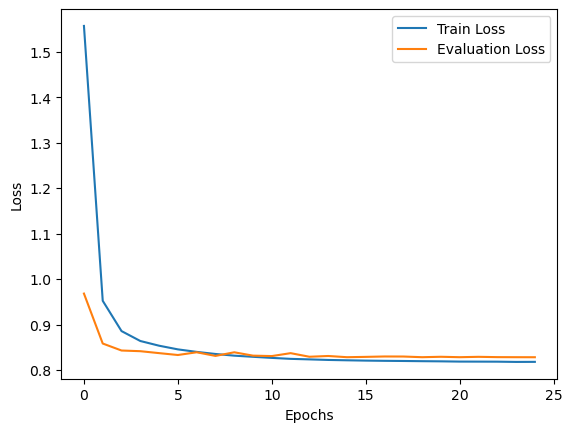

In [34]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Evaluation
model = RecommenderNet(num_users=max_user_id, num_movies=max_movie_id, embedding_size=EMBEDDING_SIZE)
model.load_state_dict(torch.load(project_root+'/models/recommender_nn_model.pth'))
model.eval()
model.to(device)
predictions = []
targets = []
with torch.no_grad():
    for user, movie, rating in test_dataloader:
        output = model(user, movie)
        predictions.extend(output.squeeze().tolist())
        targets.extend(rating.tolist())

rmse = sqrt(mean_squared_error(targets, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.9095461244054771


In [36]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1193, Predicted Rating: 4.769367694854736, Actual Rating: 5.0
Movie ID: 661, Predicted Rating: 3.734157085418701, Actual Rating: 3.0
Movie ID: 914, Predicted Rating: 4.481132507324219, Actual Rating: 3.0
Movie ID: 3408, Predicted Rating: 4.083086967468262, Actual Rating: 4.0
Movie ID: 2355, Predicted Rating: 4.130919933319092, Actual Rating: 5.0
Movie ID: 1197, Predicted Rating: 4.577457904815674, Actual Rating: 3.0
Movie ID: 1287, Predicted Rating: 4.420127868652344, Actual Rating: 5.0
Movie ID: 2804, Predicted Rating: 4.513021945953369, Actual Rating: 5.0
Movie ID: 594, Predicted Rating: 4.149550437927246, Actual Rating: 4.0
Movie ID: 919, Predicted Rating: 4.524262428283691, Actual Rating: 4.0
Movie ID: 595, Predicted Rating: 4.237360954284668, Actual Rating: 5.0
Movie ID: 938, Predicted Rating: 3.9974708557128906, Actual Rating: 4.0
Movie ID: 2398, Predicted Rating: 4.262789249420166, Actual Rating: 4.0
Movie ID: 2918, Predicted Rating: 4

In [37]:
def predict_unrated_movies(user_id, model, ratings, movies):
    #TODO
    user_data = ratings[ratings['user_id'] == user_id]
    rated_movies = user_data['movie_id']
    all_movies = ratings['movie_id'].unique()
    unrated_movies = list(set(all_movies) - set(rated_movies))
    titles = []
    genres = []
    for movie_id in unrated_movies:
        title = movies.loc[movies['movie_id'] == movie_id, 'title'].values[0]
        genre = movies.loc[movies['movie_id'] == movie_id, 'genres'].values[0]
        titles.append(title)
        genres.append(genre)
        
    user_ids = [user_id]*len(unrated_movies)
    user_ids = torch.tensor(user_ids, dtype=torch.long).to(device)
    movie_ids = torch.tensor(unrated_movies, dtype=torch.long).to(device)
    with torch.no_grad():
        predictions = model(user_ids, movie_ids).squeeze().tolist()
    predictions = list(zip(unrated_movies, titles, genres, predictions))
    predictions = sorted(predictions, key=lambda x: x[3], reverse=True)
    df = pd.DataFrame(predictions, columns=['movie_id', 'title', 'genres', 'predicted_rating'])
    return df
    

# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
predictions

,movie_id,title,genres,predicted_rating
0,1787,Paralyzing Fear: The Story of Polio in America...,Documentary,5.280672
1,557,Mamma Roma (1962),Drama,5.274910
2,3245,I Am Cuba (Soy Cuba/Ya Kuba) (1964),Drama,5.220694
3,2503,"Apple, The (Sib) (1998)",Drama,5.093840
4,787,"Gate of Heavenly Peace, The (1995)",Documentary,5.059928
...,...,...,...,...
3648,1989,Prom Night III: The Last Kiss (1989),Horror,1.742936
3649,1495,Turbo: A Power Rangers Movie (1997),Action|Adventure|Children's,1.741862
3650,3166,Brenda Starr (1989),Adventure,1.664145
3651,1538,"Second Jungle Book: Mowgli & Baloo, The (1997)",Adventure|Children's,1.556146


### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [45]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


file_path = project_root+'/data/gmm-dataset.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['URL'])
df = df.dropna()

col_means = df.mean()
col_std = df.std()
df = (df - col_means) / col_std
df = df.to_numpy()

# TODO
gmm = GaussianMixture(n_components=11)
gmm.fit(df)

# TODO
log_likelihood = gmm.score(df)
# TODO
bic = gmm.bic(df)
# TODO 
aic = gmm.aic(df)


print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

Log-Likelihood: 1.8798609964168238
BIC: 2962.776185558002
AIC: 1074.0278007166353
